# Analyze effect of time of posting

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy as tw
import datetime as dt
from matplotlib.ticker import MaxNLocator
from statsmodels.api import OLS
import json
import requests
%matplotlib inline

## Get data from Twitter API

**Setup API credentials**

In [6]:
class ConnectAPI:
    """
    - consumer_key: The consumer key from the Twitter developer account (str)
    - consumer_secret: The consumer secret key from the Twitter developer account (str)
    - access_token: The access token from the Twitter developer account (str)
    - access_token_secret: The access token secret from the Twitter developer account (str)
    """
    
    #Insert API keys
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret):
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret
        
    #Authenticate and connect to Twitter
    def connect(self):
        self.auth = tw.OAuthHandler(self.consumer_key, self.consumer_secret)
        self.auth.set_access_token(self.access_token, self.access_token_secret)
        #Setup API connection
        self.api = tw.API(self.auth, parser=tw.parsers.JSONParser())
        #Verify connection
        try:
            self.api.verify_credentials()
            print("Authentication OK")
        except:
            print("Error during authentication")   
        return self.api

In [7]:
#Load JSON with tokens
keys_dict = json.load(open('../data/tokens_twitter.json'))

#Setup credentials
api_credentials = ConnectAPI(consumer_key= keys_dict['consumer_key'],
                             consumer_secret= keys_dict['consumer_secret'],
                             access_token= keys_dict['access_token'],
                             access_token_secret= keys_dict['access_token_secret'])
#Authenticate and connect
api_connection = api_credentials.connect()

Authentication OK


**Retrieve user timeline**

In [8]:
class RetrieveTwitterData:
    """
    - user_name: The name of the Twitter handle for the account (str)
    - max_post_id: The latest post ID you would like to capture (int)
    - start_date: The date from which to start gathering the Tweet information, up until max_post_id (str)
    - api: The api connection to use (tweepy API object)
    """
    
    def __init__(self, user_name, max_post_id, start_date, api):
            
            self.user_name=user_name
            self.max_post_id=max_post_id
            self.start_date=start_date
            self.api = api
     
    #Function to retrieve data from timeline
    def data_from_timeline(self):

        #Create emtpy dataframe to append to
        self.full_df=pd.DataFrame(columns=['timestamp_post', 'tweet_id', 'tweet_url',  
                                           'tweet_text', 'retweet_count', 'favorite_count'])

        #Keep running until minimim post ID is reached (duplicate id is reached)
        while (np.isnan(self.full_df['tweet_id'].min())) or (pd.to_datetime(self.full_df['timestamp_post']).dt.date.min() > pd.to_datetime(self.start_date)):
                     
            self.timeline = self.api.user_timeline(id=self.user_name,
                                                   max_id=self.max_post_id,
                                                   exclude_replies=1, 
                                                   include_rts=0,
                                                   tweet_mode="extended")

            #Create lists to capture timestamp, Tweet ID, Tweet URL, retweet count and favorite count
            timestamp_post = []
            tweet_id = []
            tweet_url = []
            tweet_text = []
            retweet_count = []
            favorite_count = []


            #Loop through tweets and capture information
            for tweet in self.timeline:                
                #Capture timestamp, Tweet URL, retweet and favorite count
                timestamp_post.append(tweet['created_at'])
                tweet_id.append(tweet['id'])
                tweet_url.append('https://twitter.com/MinBZ/status/{}'.format(tweet['id']))
                tweet_text.append(tweet['full_text'])
                retweet_count.append(tweet['retweet_count'])
                favorite_count.append(tweet['favorite_count']) 

            #Create partial_df for the round
            self.partial_df = pd.DataFrame({'timestamp_post': timestamp_post,
                                            'tweet_id' : tweet_id,
                                            'tweet_url':  tweet_url,
                                            'tweet_text': tweet_text,
                                            'retweet_count': retweet_count,
                                            'favorite_count': favorite_count
                                           }
                                          )

            #Concatenate partial_df to full_df
            self.full_df = pd.concat([self.full_df, self.partial_df])

            #Set maximum post_id to oldest retreived post_id
            self.max_post_id = self.full_df['tweet_id'].min() 

        return self.full_df[~self.full_df['tweet_id'].duplicated()]

In [20]:
#Specify data request
data_request = RetrieveTwitterData(user_name='DutchMFA',
                                   max_post_id=1318912816988946433, 
                                   start_date='2020-01-20',
                                   api=api_connection
                                  )

In [21]:
#Create dataframe
df = data_request.data_from_timeline()

In [22]:
df.head()

,timestamp_post,tweet_id,tweet_url,tweet_text,retweet_count,favorite_count
0,Tue Oct 20 14:22:52 +0000 2020,1318558307720855552,https://twitter.com/MinBZ/status/1318558307720...,Tech entrepreneur Tey El-Rjula aims to make a ...,8,15
1,Mon Oct 19 16:45:29 +0000 2020,1318231809759522821,https://twitter.com/MinBZ/status/1318231809759...,In recent weeks coronavirus has had too many o...,26,44
2,Fri Oct 16 15:12:05 +0000 2020,1317121141916471296,https://twitter.com/MinBZ/status/1317121141916...,Young people deserve to be equipped with the s...,7,18
3,Fri Oct 16 14:43:10 +0000 2020,1317113863544971272,https://twitter.com/MinBZ/status/1317113863544...,The European Council calls upon the Russian Fe...,6,14
4,Thu Oct 15 16:13:09 +0000 2020,1316774121758490624,https://twitter.com/MinBZ/status/1316774121758...,COVID will potentially reverse decades of prog...,7,17


In [23]:
df.tail()

,timestamp_post,tweet_id,tweet_url,tweet_text,retweet_count,favorite_count
2,Thu Feb 06 16:24:00 +0000 2020,1225455110559539200,https://twitter.com/MinBZ/status/1225455110559...,Competition in the Gazan job market is high. \...,12,32
3,Tue Feb 04 17:07:05 +0000 2020,1224741176944812032,https://twitter.com/MinBZ/status/1224741176944...,Women are key to economic welfare. The Netherl...,8,37
4,Mon Jan 27 17:39:09 +0000 2020,1221850142023802880,https://twitter.com/MinBZ/status/1221850142023...,Ending child labour must be part of a much bro...,6,9
5,Mon Jan 27 08:15:32 +0000 2020,1221708305720119301,https://twitter.com/MinBZ/status/1221708305720...,We remember the liberation of the Auschwitz-Bi...,61,116
6,Sun Jan 12 11:25:59 +0000 2020,1216320413891993600,https://twitter.com/MinBZ/status/1216320413891...,The Netherlands stands in full solidarity with...,35,67


## Pre-process data

In [24]:
class PreProcessing:
    
    #Function to rename columns
    def rename_columns(dataf):

        renamed_df = (dataf
                          .rename(columns={'timestamp_post': 'date'})
                     )

        return renamed_df

    #Function to change data type
    def change_dtype(dataf):

        changed_df = (dataf
                          .assign(date = lambda d: pd.to_datetime(d['date']),
                                  retweet_count = dataf['retweet_count'].astype(int),
                                  favorite_count =  dataf['favorite_count'].astype(int)
                                 )
                     )

        return changed_df

    #Function to add columns
    def add_columns(dataf):


        add_col_df = (dataf
                         .assign(hour = lambda d: d['date'].dt.hour,
                                 day_name = lambda d: d['date'].dt.strftime('%A'),
                                 day_number = lambda d: d['date'].dt.dayofweek)
                     )

        return add_col_df
    
    #Function to add outlink URL from t.co link
    def add_outlink_redirect(dataf):

        outlink_list = []
        masked_outlink_urls = dataf['tweet_text'].str.findall('https?://[^\s]+').str[0]

        for url in masked_outlink_urls:

            if type(url) == str:
                outlink_list.append(requests.get(url).url)

            else:
                outlink_list.append('No Url')

        outlink_df = (dataf.assign(outlink_url_masked = masked_outlink_urls,
                                   outlink_url= outlink_list
                                  )
                      )

        return outlink_df

    #Remove outliers
    def remove_outliers(dataf):

        return dataf[(dataf['retweet_count'] < 30) & (dataf['favorite_count'] < 50)]  

In [25]:
clean_df = (df
            .pipe(PreProcessing.rename_columns)
            .pipe(PreProcessing.change_dtype)
            .pipe(PreProcessing.add_columns)
            .pipe(PreProcessing.add_outlink_redirect)
            .pipe(PreProcessing.remove_outliers)
           )

In [26]:
clean_df.head()

,date,tweet_id,tweet_url,tweet_text,retweet_count,favorite_count,hour,day_name,day_number,outlink_url_masked,outlink_url
0,2020-10-20 14:22:52+00:00,1318558307720855552,https://twitter.com/MinBZ/status/1318558307720...,Tech entrepreneur Tey El-Rjula aims to make a ...,8,15,14,Tuesday,1,https://t.co/UwO0or9Ry0,https://www.youthatheart.nl/latest/news/2020/1...
1,2020-10-19 16:45:29+00:00,1318231809759522821,https://twitter.com/MinBZ/status/1318231809759...,In recent weeks coronavirus has had too many o...,26,44,16,Monday,0,https://t.co/epopOrQJeY,https://www.government.nl/latest/news/2020/10/...
2,2020-10-16 15:12:05+00:00,1317121141916471296,https://twitter.com/MinBZ/status/1317121141916...,Young people deserve to be equipped with the s...,7,18,15,Friday,4,https://t.co/LrwhMUs1Tn,https://www.youthatheart.nl/latest/news/2020/1...
3,2020-10-16 14:43:10+00:00,1317113863544971272,https://twitter.com/MinBZ/status/1317113863544...,The European Council calls upon the Russian Fe...,6,14,14,Friday,4,https://t.co/TVeWkZDVS1,https://twitter.com/eucouncilpress/status/1317...
4,2020-10-15 16:13:09+00:00,1316774121758490624,https://twitter.com/MinBZ/status/1316774121758...,COVID will potentially reverse decades of prog...,7,17,16,Thursday,3,https://t.co/gagZWYdBo6,https://www.forbes.com/sites/worldeconomicforu...


In [27]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 0 to 4
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   date                71 non-null     datetime64[ns, UTC]
 1   tweet_id            71 non-null     object             
 2   tweet_url           71 non-null     object             
 3   tweet_text          71 non-null     object             
 4   retweet_count       71 non-null     int32              
 5   favorite_count      71 non-null     int32              
 6   hour                71 non-null     int64              
 7   day_name            71 non-null     object             
 8   day_number          71 non-null     int64              
 9   outlink_url_masked  68 non-null     object             
 10  outlink_url         71 non-null     object             
dtypes: datetime64[ns, UTC](1), int32(2), int64(2), object(6)
memory usage: 6.1+ KB


In [28]:
len(clean_df)

71

## Analyze & Visualize

**Retweets**

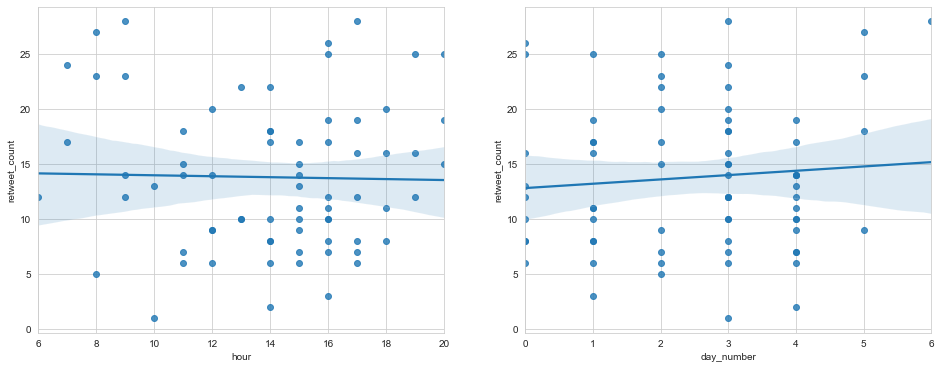

In [29]:
#Set style
sns.set_style('whitegrid')

#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Scatterplots including reg line
sns.regplot(x='hour', y='retweet_count', data=clean_df, ax=ax1)
sns.regplot(x='day_number', y='retweet_count', data=clean_df, ax=ax2);

#Set xaxisticklabels to integer
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

**Favorites**

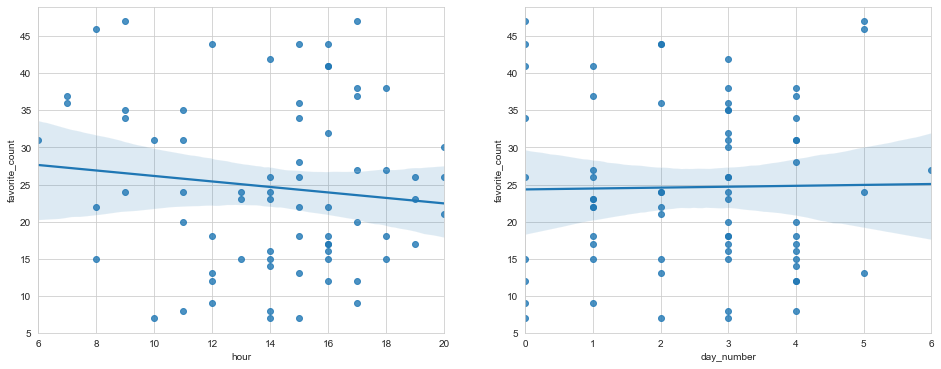

In [30]:
#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Scatterplots including reg line
sns.regplot(x='hour', y='favorite_count', data=clean_df, ax=ax1)
sns.regplot(x='day_number', y='favorite_count', data=clean_df, ax=ax2);

#Set xaxisticklabels to integer
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

**Day of week**

<ipython-input-31-97a88d804ef1>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Maandag', 'Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
<ipython-input-31-97a88d804ef1>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['Maandag', 'Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])


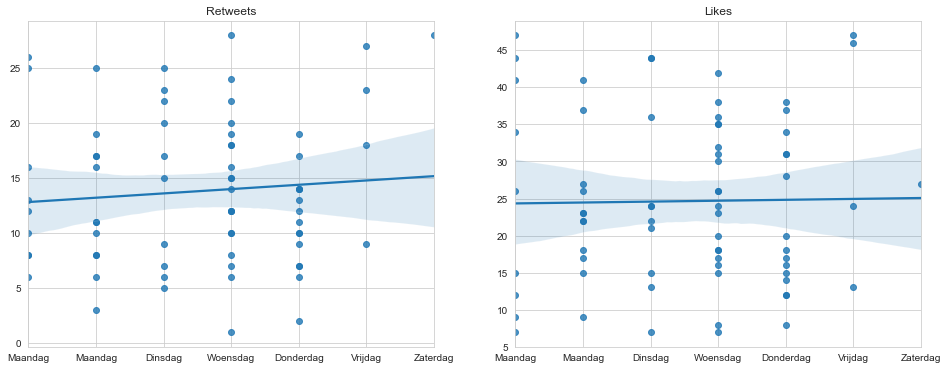

In [31]:
#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Scatterplot including reg line
sns.regplot(x='day_number', y='retweet_count', data=clean_df, ax=ax1)

#Format chart
ax1.set_xticklabels(['Maandag', 'Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title('Retweets')

#Scatterplot including reg line
sns.regplot(x='day_number', y='favorite_count', data=clean_df, ax=ax2);

#Format chart
ax2.set_xticklabels(['Maandag', 'Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title('Likes');

**Average per hour**

In [32]:
#Group by hour and capture average values
group_by_hour = (clean_df
                   .groupby('hour')
                   .mean()
                )

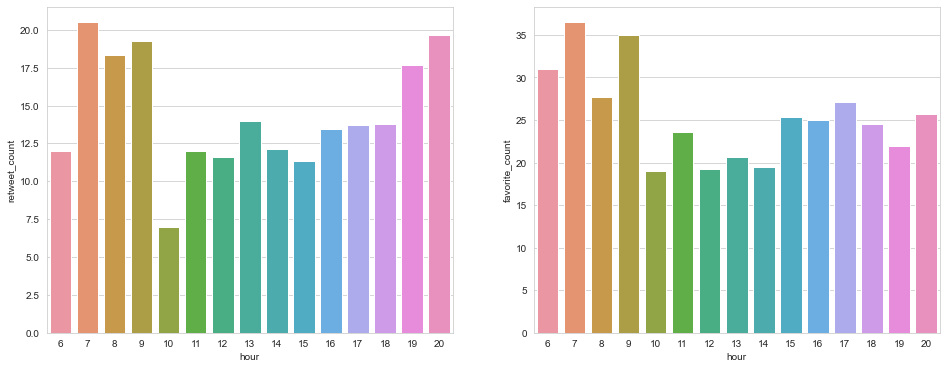

In [33]:
#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Plot barcharts
sns.barplot(x=group_by_hour.index, y='retweet_count', data=group_by_hour, ax=ax1)
sns.barplot(x=group_by_hour.index, y='favorite_count', data=group_by_hour, ax=ax2);

**Average per day**

In [34]:
#Group by hour and capture average values
group_by_day = (clean_df
                   .groupby('day_number')
                   .mean()
               )

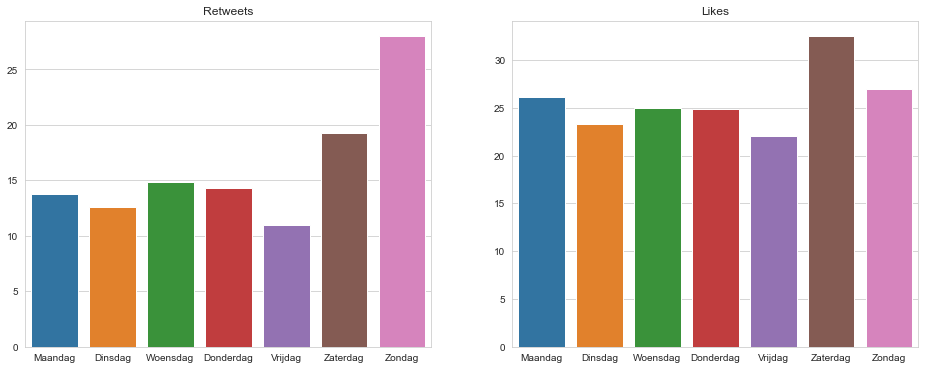

In [35]:
#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Plot retweets per day
sns.barplot(x=group_by_day.index, y='retweet_count', data=group_by_day, ax=ax1)

#Format chart
ax1.set_xticklabels(['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title('Retweets')

#Plot favorites/likes per day
sns.barplot(x=group_by_day.index, y='favorite_count', data=group_by_day, ax=ax2)

#Format chart
ax2.set_xticklabels(['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title('Likes');

## Correlation & regression

- Negative correlation between hour and retweet/favorite count
- Positive correlation between day number and retweet/favorite count

In [36]:
#Correlation df 
(clean_df
 .corr()
 .loc[['retweet_count', 'favorite_count'], ['hour', 'day_number']]
)

,hour,day_number
retweet_count,-0.022343,0.089336
favorite_count,-0.113523,0.016442


**Retweets**

In [37]:
#Define explanatory variables
X = clean_df[['hour', 'day_number']]

#Define dependent variable
y_retweet = clean_df['retweet_count']

In [38]:
#Initiate OLS regression object
reg_retweets_ols = OLS(y_retweet, X)

In [39]:
#Fit OLS model
results_retweets_ols = reg_retweets_ols.fit()

- We observe a positive effect of posting later on the day for retweets on @minbz
- We observe a positive effect of posting later in the week for retweets on @minBZ

In [40]:
#Evaluate results
results_retweets_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          retweet_count   R-squared (uncentered):                   0.787
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                              127.8
Date:                Fri, 29 Jan 2021   Prob (F-statistic):                    6.32e-24
Time:                        17:10:08   Log-Likelihood:                         -239.60
No. Observations:                  71   AIC:                                      483.2
Df Residuals:                      69   BIC:                                      487.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hour           0.7042      0.098      7.206      0.000       0.509       0.899
day_number     1.3653      0.484      2.823      0.006       0.401       2.330
==============================================================================
Omnibus:                        2.981   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.911
Skew:                           0.450   Prob(JB):                        0.233
Kurtosis:                       2.582   Cond. No.                         8.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Favorites**

In [41]:
#Define dependent variable
y_favorites = clean_df['favorite_count']

In [42]:
#Initiate OLS regression object
reg_favorites_ols = OLS(y_favorites, X)

In [43]:
#Fit OLS model
results_favorites_ols = reg_favorites_ols.fit()

- We observe a positive effect of posting later on the day for favorites on @minbz
- We observe a positive effect of posting later in the week for favorites on @minBZ

In [44]:
#Evaluate results
results_favorites_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         favorite_count   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.778
Method:                 Least Squares   F-statistic:                              125.3
Date:                Fri, 29 Jan 2021   Prob (F-statistic):                    1.08e-23
Time:                        17:11:08   Log-Likelihood:                         -280.49
No. Observations:                  71   AIC:                                      565.0
Df Residuals:                      69   BIC:                                      569.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hour           1.2798      0.174      7.362      0.000       0.933       1.627
day_number     2.1882      0.860      2.544      0.013       0.472       3.904
==============================================================================
Omnibus:                       12.285   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                5.014
Skew:                           0.393   Prob(JB):                       0.0815
Kurtosis:                       1.962   Cond. No.                         8.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""